# IELE 4014 Reto 7
**Felipe Velásquez Montoya - 201632422**

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import NuSVC
import math
import matplotlib.pyplot as plt

A continuación, se realiza la carga de los datos desde el archivo *msd_genre_dataset_segpreproc_knime.csv*. Previamente, los datos fueron preprocesados con las herramientas Knime y Excel. Con estas dos herramientas, se removieron las columnas correspondientes al nombre de la canción, el autor y el identificador único de la misma. Adicionalmente, se eliminaron todas las canciones que no pertenecían ni a la categoría "Sould and Reggae" ni "Jazz and blues". Finalmente, a estas dos categorías se les asignaron los valores 0 y 1 respectivamente.

In [2]:
data_matrix = np.loadtxt(open("./msd_genre_dataset/fixed_ds.csv", "r"), delimiter=",", skiprows=0)


print("Filas de la matriz: " + str(len(data_matrix)))
print("Columnas de la matriz: " + str(len(data_matrix[0])))


#Los datos del set de datos están agrupados por género. Es decir, primero están todas las filas que corresponden
#a 1 y después todas las que corresponden a -1. Se hace un shuffle para que, más tarde,
#no se creen unos modelos que predigan únicamente una clase.
np.random.shuffle(data_matrix)


y = data_matrix[:,len(data_matrix[0])-1]
X = np.delete(data_matrix, len(data_matrix[0])-1,1)

y = y.astype(int)


print("X shape" + str(X.shape))
print("y shape" + str(y.shape))
print(X)
print(y)

Filas de la matriz: 8330
Columnas de la matriz: 31
X shape(8330, 30)
y shape(8330,)
[[-10.114       89.97         1.         ... 243.95479133 165.37166341
  493.10135401]
 [ -7.92       106.447        3.         ... 281.0314301  379.98186407
  403.56379319]
 [-15.886      155.678        1.         ... 319.20949176 238.64434087
  443.01748739]
 ...
 [-11.203      196.379        4.         ... 273.52429227 153.46845414
  212.22035564]
 [ -8.052       91.836        4.         ... 617.44145238 669.82192135
  347.39088127]
 [ -9.631      131.941        4.         ... 517.89491395 380.32702401
  363.65400157]]
[0 0 0 ... 1 0 0]


Se decidió dedicar el 20% de los datos al conjunto de prueba y el 80% al conjunto de entrenamiento, en este segundo conjunto, se decidió implementar una técnica de validación cruzada para la selección de los modelos. Para el conjunto de validación a utilizarse en esta heurística, decidió usarse el 10% de los datos de entrenamiento. La elección de los conjuntos se hace al azar utilizando el método train_test_split de sklearn. Aunque no es posible garantizar que los conjuntos tengan la misma distribución de clases, dada la naturaleza aleatoria del método train_test_split, se espera que estas sean semejantes.

In [3]:
percentage_test = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage_test) 

print("Training set size: %s" % len(X_train))
print("Test set size: %s" % len(X_test))

Training set size: 6664
Test set size: 1666


Se procede, primero, a establacer cuál es el mejor tipo de estandarización, para esto, se comparan los resultados obtenidos cuando se utiliza StandardScaler, MinMaxScaler y RobustScaler. Como se mencionó previamente, se realizará validación cruzada con 10 grupos.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaled_X_train = []
scalers = ["StandardScaler", "MinMaxScaler", "RobustScaler"]

#Primero StandardScaler
scaler = StandardScaler().fit(X)
scaled_X_train.append(scaler.transform(X_train))

#Ahora, MinMaxScaler
scaler = MinMaxScaler().fit(X)
scaled_X_train.append(scaler.transform(X_train))

#Finalmente, RobustScaler
scaler = RobustScaler().fit(X)
scaled_X_train.append(scaler.transform(X_train))


percentage_validation = 0.1
kf = KFold(n_splits=math.floor(1/percentage_validation))

scores = []
best_score = 1
best_scaler = ""

for j in range(0, len(scalers)):
    
    i = 0
    score = 0
    print("Scaler: %s" % scalers[j])
    
    #Validación cruzada del SVM
    for train_index, test_index in kf.split(scaled_X_train[j]):
        X_train_cv, X_validate = scaled_X_train[j][train_index], scaled_X_train[j][test_index]
        y_train_cv, y_validate = y_train[train_index], y_train[test_index]
        nusvc = NuSVC(kernel = "rbf", gamma = "scale")    
        nusvc.fit(X_train_cv,y_train_cv)
    
        fold_score = nusvc.score(X_validate, y_validate)
        score += fold_score
        i+=1
        print("    FOLD %s error: %s" % (i, 1 - fold_score))
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_scaler = scalers[j]
    
    print("Average error probability for NuSVC with %s: %s" % (scalers[j], score))

print("Lowest error probability: %s for model with %s" % (best_score, best_scaler))

Scaler: StandardScaler
    FOLD 1 error: 0.16191904047976013
    FOLD 2 error: 0.1649175412293853
    FOLD 3 error: 0.15142428785607198
    FOLD 4 error: 0.1424287856071964
    FOLD 5 error: 0.16216216216216217
    FOLD 6 error: 0.16216216216216217
    FOLD 7 error: 0.13363363363363367
    FOLD 8 error: 0.16666666666666663
    FOLD 9 error: 0.14414414414414412
    FOLD 10 error: 0.1561561561561562
Average error probability for NuSVC with StandardScaler: 0.15456145800973398
Scaler: MinMaxScaler
    FOLD 1 error: 0.1784107946026986
    FOLD 2 error: 0.17991004497751129
    FOLD 3 error: 0.15592203898050971
    FOLD 4 error: 0.15592203898050971
    FOLD 5 error: 0.16216216216216217
    FOLD 6 error: 0.17267267267267272
    FOLD 7 error: 0.15465465465465467
    FOLD 8 error: 0.18768768768768773
    FOLD 9 error: 0.17267267267267272
    FOLD 10 error: 0.1636636636636637
Average error probability for NuSVC with MinMaxScaler: 0.16836784310547426
Scaler: RobustScaler
    FOLD 1 error: 0.164917

Como puede observarse, el mejor puntaje es obtenido con la utilización del StandardScaler. Se procese a escalar el conjunto de datos de entrenamiento utilizando esta técnica.

In [5]:
scaler = StandardScaler().fit(X)
X_train = scaler.transform(X_train)

A continuación, se buscará el mejor valor para la constante Nu.

In [6]:
percentage_validation = 0.1
kf = KFold(n_splits=math.floor(1/percentage_validation))

nus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scores = []
best_score = 1
best_nu = -1

for nu in nus:

    i = 0
    score = 0
    print("Nu: %s" %nu)
    #Validación cruzada del SVM
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_validate = X_train[train_index], X_train[test_index]
        y_train_cv, y_validate = y_train[train_index], y_train[test_index] 
        nusvc = NuSVC(kernel = "rbf", gamma = "scale", nu = nu)    
        nusvc.fit(X_train_cv,y_train_cv)
        fold_score = nusvc.score(X_validate, y_validate)
        score += fold_score
        i+=1
        print("    FOLD %s error: %s" % (i, 1 - fold_score))
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_nu = nu
    
    print("Average error probability for NuSVC with rbf and a nu of %s: %s" % (nu, score))

print("Lowest error probability: %s for model with rbf and a nu of %s" % (best_score, best_nu))

Nu: 0.1
    FOLD 1 error: 0.15442278860569714
    FOLD 2 error: 0.15292353823088456
    FOLD 3 error: 0.14392803598200898
    FOLD 4 error: 0.1274362818590704
    FOLD 5 error: 0.1561561561561562
    FOLD 6 error: 0.1561561561561562
    FOLD 7 error: 0.1351351351351351
    FOLD 8 error: 0.1576576576576577
    FOLD 9 error: 0.14864864864864868
    FOLD 10 error: 0.14714714714714716
Average error probability for NuSVC with rbf and a nu of 0.1: 0.14796115455785608
Nu: 0.2
    FOLD 1 error: 0.14092953523238383
    FOLD 2 error: 0.1214392803598201
    FOLD 3 error: 0.12443778110944526
    FOLD 4 error: 0.11544227886056968
    FOLD 5 error: 0.13813813813813813
    FOLD 6 error: 0.12462462462462465
    FOLD 7 error: 0.12012012012012008
    FOLD 8 error: 0.14114114114114118
    FOLD 9 error: 0.13813813813813813
    FOLD 10 error: 0.14114114114114118
Average error probability for NuSVC with rbf and a nu of 0.2: 0.13055521788655222
Nu: 0.3
    FOLD 1 error: 0.13793103448275867
    FOLD 2 error: 

Como puede observarse, el mejor valor se obtuvo con nu = 0.3, es decir que, a lo sumo, se permite clasificar incorrectamente el 30% de los X de entrenamiento y, por lo menos, el 30% de los X de entrenamiento son vectores de soporte.

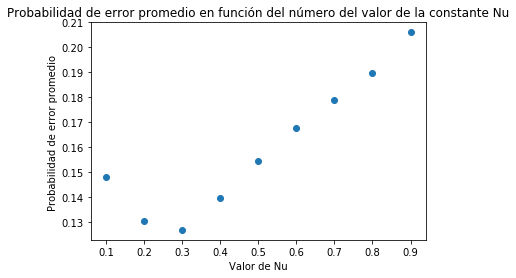

In [7]:
plt.plot(nus, scores, 'o')
#plt.xticks(range(1,max_degree+1))
plt.xlabel('Valor de Nu')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número del valor de la constante Nu')
plt.show()

NuSVC permite escoger también si se utiliza la eurística Shrinking, la cual intenta reducir el problema de optimización (véase https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf. Se verá, ahora, si el desempeño del modelo se ve afectado al utilizar esta heurística. 

In [8]:
percentage_validation = 0.1
kf = KFold(n_splits=math.floor(1/percentage_validation))

shrinkings = [False, True]
best_score = 1
best_shrinking = "None"

for shrinking in shrinkings:

    i = 0
    score = 0
    print("Shrinking: %s" %shrinking)
    #Validación cruzada del SVM
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_validate = X_train[train_index], X_train[test_index]
        y_train_cv, y_validate = y_train[train_index], y_train[test_index] 
        nusvc = NuSVC(kernel = "rbf", gamma = "scale", nu = 0.3, shrinking = shrinking)    
        nusvc.fit(X_train_cv,y_train_cv)
        fold_score = nusvc.score(X_validate, y_validate)
        score += fold_score
        i+=1
        print("    FOLD %s error: %s" % (i, 1 - fold_score))
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_shrinking = shrinking
    
    print("Average error probability for NuSVC with rbf and shrinking %s: %s" % (shrinking, score))

print("Lowest error probability: %s for model with rbf and a shrinking %s" % (best_score, best_shrinking))

Shrinking: False
    FOLD 1 error: 0.13793103448275867
    FOLD 2 error: 0.1274362818590704
    FOLD 3 error: 0.11694152923538226
    FOLD 4 error: 0.12293853073463268
    FOLD 5 error: 0.13963963963963966
    FOLD 6 error: 0.12012012012012008
    FOLD 7 error: 0.11111111111111116
    FOLD 8 error: 0.13213213213213215
    FOLD 9 error: 0.1426426426426426
    FOLD 10 error: 0.11861861861861867
Average error probability for NuSVC with rbf and shrinking False: 0.12695116405761087
Shrinking: True
    FOLD 1 error: 0.13793103448275867
    FOLD 2 error: 0.1274362818590704
    FOLD 3 error: 0.11694152923538226
    FOLD 4 error: 0.12293853073463268
    FOLD 5 error: 0.13963963963963966
    FOLD 6 error: 0.12012012012012008
    FOLD 7 error: 0.11111111111111116
    FOLD 8 error: 0.13213213213213215
    FOLD 9 error: 0.1426426426426426
    FOLD 10 error: 0.11861861861861867
Average error probability for NuSVC with rbf and shrinking True: 0.12695116405761087
Lowest error probability: 0.1269511640

Como puede observarse, la heurística no afecta el desempeño del modelo.

Analizar Shrinking

A continuación se escogerá Gamma, SK Learn da dos opciones para gamma

In [9]:
percentage_validation = 0.1
kf = KFold(n_splits=math.floor(1/percentage_validation))

gammas = ["auto", "scale"]
best_score = 1
best_gamma = "None"

for gamma in gammas:

    i = 0
    score = 0
    print("Gamma: %s" %gamma)
    #Validación cruzada del SVM
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_validate = X_train[train_index], X_train[test_index]
        y_train_cv, y_validate = y_train[train_index], y_train[test_index] 
        nusvc = NuSVC(kernel = "rbf", gamma = gamma, nu = 0.3, shrinking = False)    
        nusvc.fit(X_train_cv,y_train_cv)
        fold_score = nusvc.score(X_validate, y_validate)
        score += fold_score
        i+=1
        print("    FOLD %s error: %s" % (i, 1 - fold_score))
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_gamma = gamma
    
    print("Average error probability for NuSVC with rbf and a gamma of %s: %s" % (gamma, score))

print("Lowest error probability: %s for model with rbf and a gamma of %s" % (best_score, best_gamma))

Gamma: auto
    FOLD 1 error: 0.13793103448275867
    FOLD 2 error: 0.1274362818590704
    FOLD 3 error: 0.11694152923538226
    FOLD 4 error: 0.12293853073463268
    FOLD 5 error: 0.13813813813813813
    FOLD 6 error: 0.12012012012012008
    FOLD 7 error: 0.11111111111111116
    FOLD 8 error: 0.13213213213213215
    FOLD 9 error: 0.1426426426426426
    FOLD 10 error: 0.11861861861861867
Average error probability for NuSVC with rbf and a gamma of auto: 0.1268010139074608
Gamma: scale
    FOLD 1 error: 0.13793103448275867
    FOLD 2 error: 0.1274362818590704
    FOLD 3 error: 0.11694152923538226
    FOLD 4 error: 0.12293853073463268
    FOLD 5 error: 0.13963963963963966
    FOLD 6 error: 0.12012012012012008
    FOLD 7 error: 0.11111111111111116
    FOLD 8 error: 0.13213213213213215
    FOLD 9 error: 0.1426426426426426
    FOLD 10 error: 0.11861861861861867
Average error probability for NuSVC with rbf and a gamma of scale: 0.12695116405761087
Lowest error probability: 0.1268010139074608 

Escoger class_weight

ones: 3449| zeroes: 3215


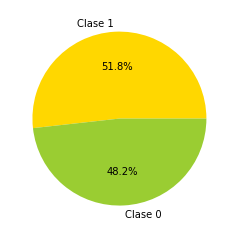

In [10]:
def count_occurrences(y):
    ones=0
    zeroes=0
    
    for i in range(0,len(y)):
        if y[i] == 1:
            ones+=1
        else:
            zeroes+=1
    return ones, zeroes

one, zero = count_occurrences(y_train)

print("ones: %s| zeroes: %s" % (one, zero))

labels = "Clase 1", "Clase 0"
colors = ['gold', 'yellowgreen']
plt.pie([one, zero], labels= labels, colors=colors, autopct='%1.1f%%')
plt.show()

Se asgina, entonces, un class_weight proporcional a la frecuencia de las clases en nuestros datos de entrenamiento. Como puede observarse, esto disminuye la probabilidad de error observada.

In [14]:
percentage_validation = 0.1
kf = KFold(n_splits=math.floor(1/percentage_validation))

class_weight = {0:(zero)/(one+zero), 1:(one)/(one+zero)}

#Validación cruzada del SVM
i=0
score = 0
for train_index, test_index in kf.split(X_train):
    X_train_cv, X_validate = X_train[train_index], X_train[test_index]
    y_train_cv, y_validate = y_train[train_index], y_train[test_index] 
    nusvc = NuSVC(kernel = "rbf", gamma = "scale", nu = 0.3, shrinking = False, class_weight = class_weight) 
    nusvc.fit(X_train_cv,y_train_cv)
    fold_score = nusvc.score(X_validate, y_validate)
    score += fold_score
    i+=1
    print("    FOLD %s error: %s" % (i, 1 - fold_score))
    
score = 1 - (score/i)    
print("Error probability for class_weight %s: %s" % (class_weight, score))

    FOLD 1 error: 0.13793103448275867
    FOLD 2 error: 0.1274362818590704
    FOLD 3 error: 0.11694152923538226
    FOLD 4 error: 0.12293853073463268
    FOLD 5 error: 0.13963963963963966
    FOLD 6 error: 0.12012012012012008
    FOLD 7 error: 0.11111111111111116
    FOLD 8 error: 0.13213213213213215
    FOLD 9 error: 0.1426426426426426
    FOLD 10 error: 0.11861861861861867
Error probability for class_weight {0: 0.48244297719087637, 1: 0.5175570228091236}: 0.12695116405761087


## Modelo Final
De acuerdo con el proceso llevado a cabo, el modelo final será un clasificador NuSVC con kernel Gaussiano (rbf), un gamma de "auto", es decir 1/30, un Nu de 0.3, sin utilizar la heurística Shrinking y utilizando un class_weight propocional a las razones de las clases en el conjunto de entrenamiento. A continuación, se entrena el modelo final sobre todos los datos de entrenamiento y se prueba su desempeño.


In [15]:
#Se estandarizan los datos de prueba
scaler = StandardScaler().fit(X)
X_test = scaler.transform(X_test)

In [17]:

nusvc = NuSVC(kernel = "rbf", gamma = "auto", nu = 0.3, shrinking = False, class_weight = class_weight) 
nusvc.fit(X_train,y_train)

final_score_train = nusvc.score(X_train, y_train)
final_score_test = nusvc.score(X_test, y_test)

print("Error probability for final model on train data %s" % (1-final_score_train))
print("Error probability for final model on test data %s" % (1-final_score_test))

Error probability for final model on train data 0.07187875150060019
Error probability for final model on test data 0.1296518607442977


//TODO, confianza del modelo final